In [1]:
import csv
import json

import matplotlib
matplotlib.use('nbagg')
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

In [2]:
# Load in the data into a multi-index frame
labels = sorted(
    open("data/reference/label_order.csv").read().strip().split(',')
)
settings = json.load(fp=open("data/reference/settings.json"))
n_instances = settings['n_iterations'] * settings['n_splits']

# Bar plot function definition

dfs : `dict`
    
    A dictionary of conditions to plot. The keys should be what you would like displayed in the legend.

cmap : `list`
    
    A list of floats indicating gray scale tone to use for each bar in a single subplot. 0 is black, 1 is white.

labels : `list`
    
    List of labels corresponding to each subplot.

In [3]:
def basic_bar_plot(dfs, cmap, labels, metric="Binary F1", keys_are_metrics=False, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                   yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], legend_colspan=2, legend_pos="upper left",
                   gs_rows=3, gs_cols=8, gs_params=dict(left=0.05, right=0.95, wspace=0.1, hspace=0.4), plot_subsets=False, 
                   ecolor="black", edgecolor="white", fontsize=8, subset_fontsize=7, center_left=None, center_right=None,
                   use_subset_ticks=True, n_instances=n_instances):
    
    f = plt.figure()
    gs = GridSpec(gs_rows, gs_cols)
    gs.update(**gs_params)
    axes = []
    
    for i in range(0, gs_rows):
        for j in range(0, gs_cols - legend_colspan):
            row_maj_idx = 6*i + j
            label = labels[row_maj_idx]
            print(label)

            ax = plt.subplot(gs[i, j])
            axes.append(ax)
            ax.margins(0.05)

            # Limits config
            ax.set_ylim(bottom=0.0)
            ax.set_ylim(top=1.0)

            # Ticks config
            ax.set_xticks([])
            ax.set_yticks([])

            ax.set(yticks=yticks, yticklabels=[])
            minor_ticks = MultipleLocator(0.1)
            ax.yaxis.set_minor_locator(minor_ticks)
            ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
            ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
            if row_maj_idx in [0, 6, 12]:
                ax.set(yticklabels=yticklabels)

            # Title config
            ax.set_title(label.capitalize())
            ax.title.set_fontsize(fontsize)

            # plot the data for each metric, using gray-scale colors               
            # Plot testing statistics for phosphorylation and dephosphorylation
            if label in ('Phosphorylation', 'Dephosphorylation') and plot_subsets:
                gap = 0.025
                bar_width = (0.5 - gap) / len(dfs)
                validation_x = np.arange(0, 0.5 - gap, bar_width)
                holdout_x = np.arange(0.5 + gap, 1.0, bar_width)
                subset_x = {"validation": validation_x, "holdout": holdout_x}

                for idx, subset in enumerate(('validation', 'holdout')):
                    print("\t{}".format(subset))
                    for bar_idx, (key, df) in enumerate(dfs.items()):
                        metric_key = key if keys_are_metrics else metric
                        score = df.loc[(label, subset, metric_key), :].mean(axis=0, level=[0]).mean()
                        stdev = df.loc[(label, subset, metric_key), :].std(axis=0, level=[0]).mean()
                        stderr = stdev / np.sqrt(n_instances) # 5 bootstrap * 5 fold = 25 observations
                        print("\t\t{}: mean,stderr => {:.4f} +- {:.4f}".format(key, score, stderr))
                        ax.bar(
                            left=subset_x[subset][bar_idx], height=score, width=bar_width, yerr=stderr,
                            color=str(cmap[bar_idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                            error_kw=dict(lw=0.5, capsize=2.5, label=key)
                        )
                        
                    if not center_left:
                        center_left = validation_x[int(len(dfs) / 2)]
                    if not center_right:
                        center_right = holdout_x[int(len(dfs) / 2)]                        
                    if use_subset_ticks:
                        ax.set(xticks=[center_left, center_right], xticklabels=['Validation', 'Holdout'])
                        ax.tick_params(axis='x', direction='in', length=2.5, labelsize=subset_fontsize)

            else:
                bar_width = 1.0 / len(dfs)
                x_positions = np.arange(0, 1, bar_width)
                for idx, (key, df) in enumerate(dfs.items()):
                    metric_key = key if keys_are_metrics else metric
                    score = df.loc[(label, 'validation', metric_key), :].mean(axis=0, level=[0]).mean()
                    stdev = df.loc[(label, 'validation', metric_key), :].std(axis=0, level=[0]).mean()
                    stderr = stdev / np.sqrt(n_instances)
                    print("\t{}: mean,stderr => {:.6f} +- {:.6f}".format(key, score, stderr))
                    ax.bar(
                        left=x_positions[idx], height=score, width=bar_width, yerr=stderr,
                        color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                        error_kw=dict(lw=0.5, capsize=2.5, label=key)
                    )
                    

    # Create the legend in a separate axis object at the right end.
    ax = plt.subplot(gs[:, -legend_colspan:])
    axes.append(ax)
    lines = []
    for idx, key in enumerate(dfs.keys()):
        lines.append(mlines.Line2D([], [], color=str(cmap[idx]), label=key))
    ax.legend(handles=lines, loc=legend_pos)
    ax.set_axis_off()

    plt.show()
    return f, axes, gs

# Baseline performance

Below is the code relating to figure 2 in the publication. It's not the cleanest code, but it gets the job done.

Acetylation
	Binary F1: mean,stderr => 0.770755 +- 0.024365
	Precision: mean,stderr => 0.713195 +- 0.026666
	Recall: mean,stderr => 0.847111 +- 0.026345
Activation
	Binary F1: mean,stderr => 0.942204 +- 0.000386
	Precision: mean,stderr => 0.950893 +- 0.000382
	Recall: mean,stderr => 0.933684 +- 0.000848
Binding/association
	Binary F1: mean,stderr => 0.872576 +- 0.001182
	Precision: mean,stderr => 0.823156 +- 0.002124
	Recall: mean,stderr => 0.928475 +- 0.001986
Carboxylation
	Binary F1: mean,stderr => 1.000000 +- 0.000000
	Precision: mean,stderr => 1.000000 +- 0.000000
	Recall: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	Binary F1: mean,stderr => 0.204857 +- 0.049972
	Precision: mean,stderr => 0.135048 +- 0.034241
	Recall: mean,stderr => 0.480000 +- 0.109545
Dephosphorylation
	validation
		Binary F1: mean,stderr => 0.9677 +- 0.0015
		Precision: mean,stderr => 0.9498 +- 0.0030
		Recall: mean,stderr => 0.9866 +- 0.0015
	holdout
		Binary F1: mean,stderr => 0.5993 +- 0.0069
		Precis

<IPython.core.display.Javascript object>


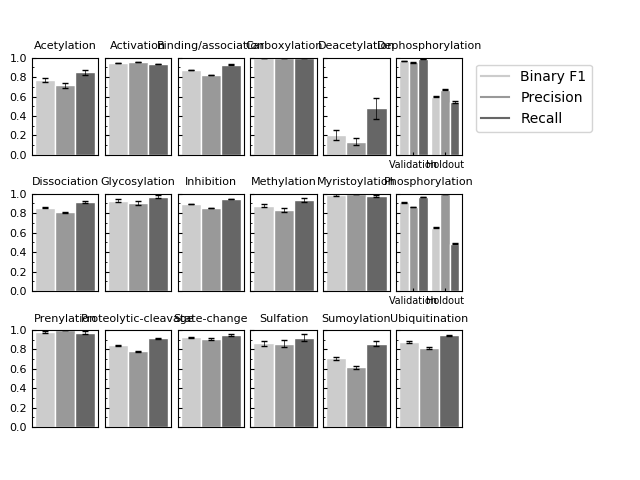

In [14]:
binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
dfs = {
    "Precision": binary_df,
    "Recall": binary_df,
    "Binary F1": binary_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, keys_are_metrics=True, plot_subsets=True);

# Random Forest

This code constructs the plot relating to the F1 score for alternate classifiers.

Acetylation
	Random Forest: mean,stderr => 0.780990 +- 0.017281
	Logistic Reg.: mean,stderr => 0.770755 +- 0.024365
Activation
	Random Forest: mean,stderr => 0.977450 +- 0.000716
	Logistic Reg.: mean,stderr => 0.942204 +- 0.000386
Binding/association
	Random Forest: mean,stderr => 0.931068 +- 0.002979
	Logistic Reg.: mean,stderr => 0.872576 +- 0.001182
Carboxylation
	Random Forest: mean,stderr => 0.986667 +- 0.005963
	Logistic Reg.: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	Random Forest: mean,stderr => 0.262190 +- 0.052225
	Logistic Reg.: mean,stderr => 0.204857 +- 0.049972
Dephosphorylation
	validation
		Random Forest: mean,stderr => 0.9637 +- 0.0027
		Logistic Reg.: mean,stderr => 0.9677 +- 0.0015
	holdout
		Random Forest: mean,stderr => 0.7325 +- 0.0106
		Logistic Reg.: mean,stderr => 0.5993 +- 0.0069
Dissociation
	Random Forest: mean,stderr => 0.876160 +- 0.007333
	Logistic Reg.: mean,stderr => 0.856677 +- 0.006900
Glycosylation
	Random Forest: mean,stderr => 0.909655 +- 

<IPython.core.display.Javascript object>


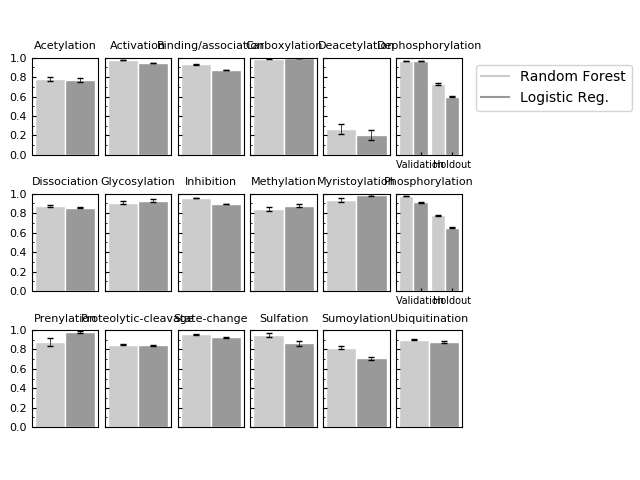

In [6]:
logistic_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
rf_df = binary_df = pd.read_csv(
    "data/randomforest/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Logistic Reg.": logistic_df,
    "Random Forest": rf_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True);

# ULCA Inducer

This code computes the figure that compares ULCA induction F1 score performance using logistic regression vs no feature induction.

Acetylation
	ULCA Inducer: mean,stderr => 0.748340 +- 0.023608
	Leaf Terms: mean,stderr => 0.770755 +- 0.024365
Activation
	ULCA Inducer: mean,stderr => 0.947550 +- 0.000432
	Leaf Terms: mean,stderr => 0.942204 +- 0.000386
Binding/association
	ULCA Inducer: mean,stderr => 0.889003 +- 0.000999
	Leaf Terms: mean,stderr => 0.872576 +- 0.001182
Carboxylation
	ULCA Inducer: mean,stderr => 0.986667 +- 0.005963
	Leaf Terms: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	ULCA Inducer: mean,stderr => 0.267746 +- 0.050938
	Leaf Terms: mean,stderr => 0.204857 +- 0.049972
Dephosphorylation
	validation
		ULCA Inducer: mean,stderr => 0.9662 +- 0.0013
		Leaf Terms: mean,stderr => 0.9677 +- 0.0015
	holdout
		ULCA Inducer: mean,stderr => 0.5835 +- 0.0055
		Leaf Terms: mean,stderr => 0.5993 +- 0.0069
Dissociation
	ULCA Inducer: mean,stderr => 0.844356 +- 0.006520
	Leaf Terms: mean,stderr => 0.856677 +- 0.006900
Glycosylation
	ULCA Inducer: mean,stderr => 0.938014 +- 0.012878
	Leaf Terms: mean,stderr

<IPython.core.display.Javascript object>


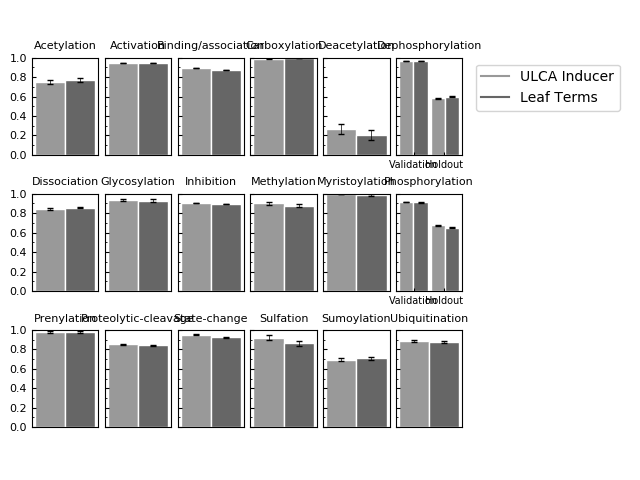

In [7]:
# TODO: GENERATE THESE DATASETS
ulca_df = binary_df = pd.read_csv(
    "data/ulca/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
noulca_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "ULCA Inducer": ulca_df,
    "Leaf Terms": noulca_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

# Binary Encoding

This code computes the figure that compares binary feature encoding F1 score performance using logistic regression vs ternary feature encoding

Acetylation
	Binary encoding: mean,stderr => 0.763223 +- 0.015666
	Ternary encoding: mean,stderr => 0.770755 +- 0.024365
Activation
	Binary encoding: mean,stderr => 0.953226 +- 0.000429
	Ternary encoding: mean,stderr => 0.942204 +- 0.000386
Binding/association
	Binary encoding: mean,stderr => 0.902656 +- 0.001097
	Ternary encoding: mean,stderr => 0.872576 +- 0.001182
Carboxylation
	Binary encoding: mean,stderr => 0.973333 +- 0.011926
	Ternary encoding: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	Binary encoding: mean,stderr => 0.177619 +- 0.045376
	Ternary encoding: mean,stderr => 0.204857 +- 0.049972
Dephosphorylation
	validation
		Binary encoding: mean,stderr => 0.9739 +- 0.0015
		Ternary encoding: mean,stderr => 0.9677 +- 0.0015
	holdout
		Binary encoding: mean,stderr => 0.6370 +- 0.0053
		Ternary encoding: mean,stderr => 0.5993 +- 0.0069
Dissociation
	Binary encoding: mean,stderr => 0.849890 +- 0.009784
	Ternary encoding: mean,stderr => 0.856677 +- 0.006900
Glycosylation
	Bi

<IPython.core.display.Javascript object>


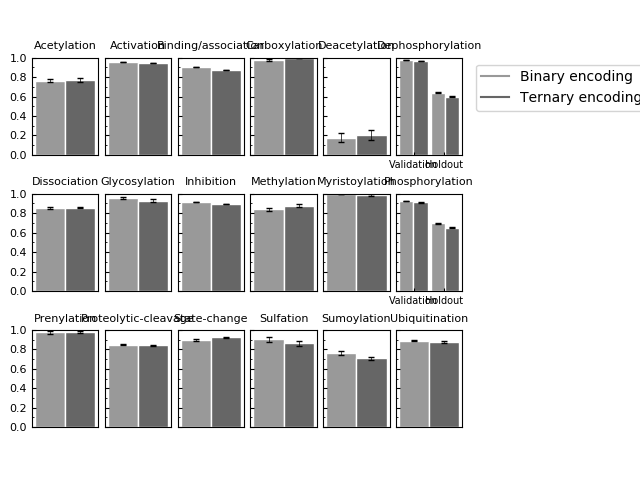

In [8]:
# TODO: GENERATE THESE DATASETS
ternary_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
binary_df = binary_df = pd.read_csv(
    "data/binary/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Binary encoding": binary_df,
    "Ternary encoding": ternary_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

# Label Ranking-Loss

This code computes the average ranking loss over all iterations and folds.

In [19]:
for file_name in ['reference', 'binary', 'ulca', 'randomforest']:
    ml_stats = binary_df = pd.read_csv(
        "data/{}/multilabel_stats.csv".format(file_name),
        index_col=[0, 1],
        header=[0, 1]
    )
    for key in ['Label Ranking Loss']:
        score = ml_stats.loc[("validation", key), ].mean(axis=0, level=[0]).mean()
        stdev = ml_stats.loc[("validation", key), ].std(axis=0, level=[0]).mean()
        stderr = stdev / np.sqrt(n_instances)
        print("{}\n\t{}\n\t\tmean,stderr => {:.4f} +- {:.6f}".format(file_name, key, score, stderr))

reference
	Label Ranking Loss
		mean,stderr => 0.0637 +- 0.000414
binary
	Label Ranking Loss
		mean,stderr => 0.0553 +- 0.000509
ulca
	Label Ranking Loss
		mean,stderr => 0.0603 +- 0.000458
randomforest
	Label Ranking Loss
		mean,stderr => 0.0352 +- 0.000805


# Specificity

This code constructs the specificity plot. The validation and holdout results are both included since specificity can still be validly defined when no positive cases exist in the dataset (as in the case with our holdout set for many labels).

Acetylation
	validation: mean,stderr => 0.9993 +- 0.0001
	holdout: mean,stderr => 0.9986 +- 0.0001
Activation
	validation: mean,stderr => 0.9150 +- 0.0007
	holdout: mean,stderr => 0.5556 +- 0.0019
Binding/association
	validation: mean,stderr => 0.9650 +- 0.0005
	holdout: mean,stderr => 0.7662 +- 0.0019
Carboxylation
	validation: mean,stderr => 1.0000 +- 0.0000
	holdout: mean,stderr => 1.0000 +- 0.0000
Deacetylation
	validation: mean,stderr => 0.9995 +- 0.0001
	holdout: mean,stderr => 0.9989 +- 0.0003
Dephosphorylation
	validation: mean,stderr => 0.9978 +- 0.0001
	holdout: mean,stderr => 0.9810 +- 0.0005
Dissociation
	validation: mean,stderr => 0.9988 +- 0.0001
	holdout: mean,stderr => 0.9948 +- 0.0003
Glycosylation
	validation: mean,stderr => 0.9998 +- 0.0000
	holdout: mean,stderr => 0.9995 +- 0.0002
Inhibition
	validation: mean,stderr => 0.9502 +- 0.0004
	holdout: mean,stderr => 0.7996 +- 0.0015
Methylation
	validation: mean,stderr => 0.9997 +- 0.0000
	holdout: mean,stderr => 0.9998 +

<IPython.core.display.Javascript object>


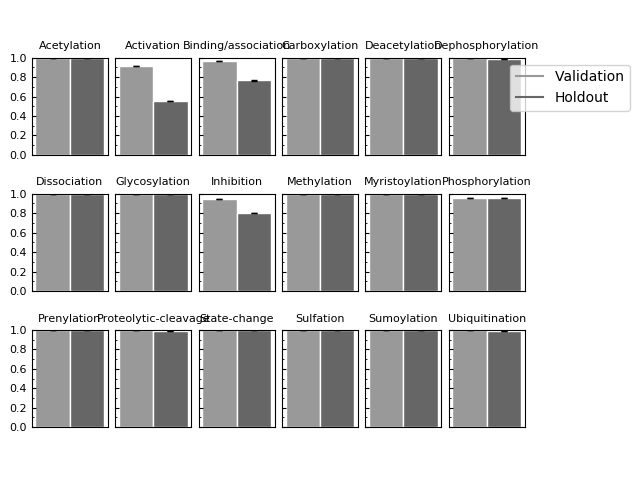

In [13]:
f = plt.figure()
binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
cmap = [0.6, 0.4]
ecolor='black'
edgecolor='white'

gs1 = GridSpec(3, 7)
gs1.update(left=0.05, right=0.95, wspace=0.1, hspace=0.4)
for i in range(0, 3):
    for j in range(0, 6):
        row_maj_idx = 6*i + j
        label = labels[row_maj_idx]
        print(label)
        
        ax = plt.subplot(gs1[i, j])
        ax.margins(0.05)
        
        # Limits config
        ax.set_ylim(bottom=0.0)
        ax.set_ylim(top=1.0)
               
        # Ticks config
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set(yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels=[])
        minor_ticks = MultipleLocator(0.1)
        ax.yaxis.set_minor_locator(minor_ticks)
        ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
        ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
        if row_maj_idx in [0, 6, 12]:
            ax.set(yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        
        # Title config
        ax.set_title(label.capitalize())
        ax.title.set_fontsize(8)
        
        # plot the data for each metric, using gray-scale colors               
        # Plot testing statistics for phosphorylation and dephosphorylation
        validation_x = [0.40]
        holdout_x = [0.60]
        subset_x = {"validation": validation_x, "holdout": holdout_x}
        bar_width = 0.20

        for idx, subset in enumerate(('validation', 'holdout')):
            spec = binary_df.loc[(label, subset, 'Specificity'), :].mean(axis=0, level=[0]).mean()
            stdev = binary_df.loc[(label, subset, 'Specificity'), :].std(axis=0, level=[0]).mean()
            stderr = stdev / np.sqrt(n_instances)
            print("\t{}: mean,stderr => {:.4f} +- {:.4f}".format(subset, spec, stderr))
            ax.bar(
                left=subset_x[subset][0], height=spec, width=bar_width, yerr=stderr,
                color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                error_kw=dict(lw=0.5, capsize=2.5, label='Specificity')
            )

# Create the legend in a separate axis object at the right end.
ax = plt.subplot(gs1[:, -1])
line1 = mlines.Line2D([], [], color=str(cmap[0]), label='Validation')
line2 = mlines.Line2D([], [], color=str(cmap[1]), label='Holdout')
ax.legend(handles=[line1, line2], loc='upper center')
ax.set_axis_off()

plt.show()

# Label Correlation Heatmap

This code produces the plot for the label correlation heatmap using the Spearman Correlation coefficient.

<IPython.core.display.Javascript object>


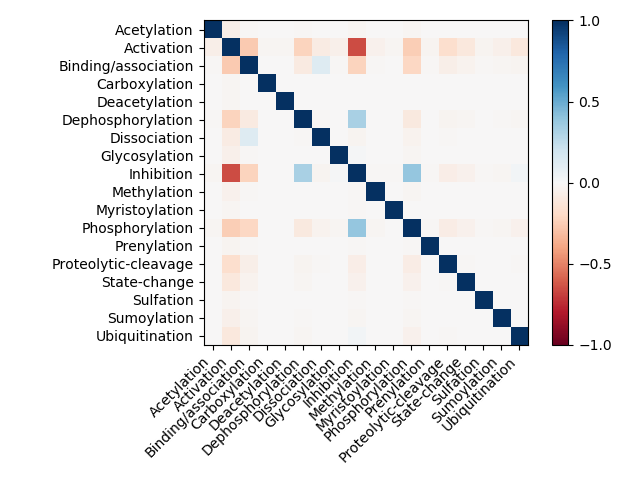

In [23]:
data = np.genfromtxt("data/reference/label_spearmanr.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]
fig, ax = plt.subplots(1, 1)
# ax.xaxis.tick_top()

ax.set_xticks(range(0, 18))
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 10})

ax.set_yticks(range(0, 18))
ax.set_yticklabels(ticklabels, fontdict={'size': 10})

im = ax.imshow(data, interpolation='none', cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(im, ticks=[-1., -0.5, 0., 0.5, 1.])

plt.tight_layout()
plt.savefig('spearman.png', format='png', dpi=600, orientation="landscape")
plt.show()

# Label Similarity Heatmaps

This code produces the plot for the label feature similarity heatmap using the Jaccard similarity measure.

The right subplot is the label feature similarity heatmap using the Jaccard similarity measure on the labels in the holdout set only.

<IPython.core.display.Javascript object>


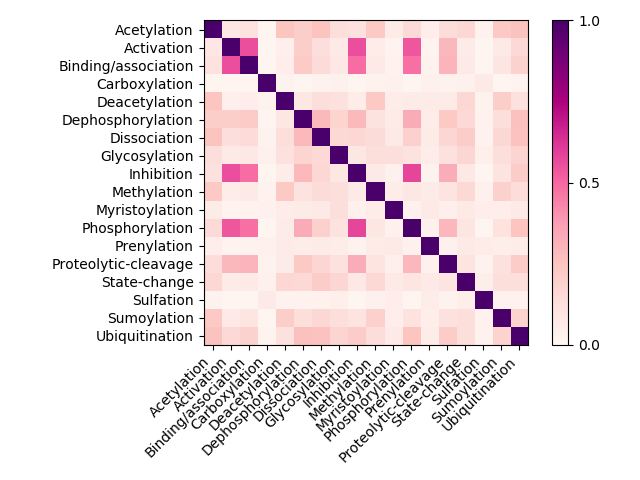

In [24]:
# data1 = np.genfromtxt("data/reference/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
# data2 = np.genfromtxt("data/reference/j_t_similarity_matrix.csv", skip_header=True, delimiter=',')

# v_ticklabels = [l.capitalize() for l in labels]
# t_ticklabels = [l.capitalize() for l in sorted(('phosphorylation', 'dephosphorylation'))]

# fig = plt.figure(figsize=(6, 8))
# gs = GridSpec(
#     1, 2, width_ratios=[1, 1], 
#     wspace=0.0, hspace=0.0, 
#     top=0.95, bottom=0.15, left=0.15, right=0.75
# )
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])

# ax1.set_xticks(range(0, 18))
# ax1.set_xticklabels(v_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
# ax1.set_yticks(range(0, 18))
# ax1.set_yticklabels(v_ticklabels, fontdict={'size': 7})

# ax2.set_xticks(range(0, 18))
# ax2.set_xticklabels(t_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
# ax2.set_yticks(range(0, 18))
# ax2.set_yticklabels(v_ticklabels, fontdict={'size': 7})
    
# im1 = ax1.imshow(data1, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
# im2 = ax2.imshow(data2.T, interpolation='none', cmap='RdPu', vmin=0, vmax=1)

# fig.colorbar(im1)

# plt.tight_layout()
# plt.show()

data = np.genfromtxt("data/reference/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]
fig, ax = plt.subplots(1, 1)

ax.set_xticks(range(0, 18))
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 10})

ax.set_yticks(range(0, 18))
ax.set_yticklabels(ticklabels, fontdict={'size': 10})

im = ax.imshow(data, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
fig.colorbar(im, ticks=[0., .5, 1.])

plt.tight_layout()
plt.savefig('jaccard.png', format='png', dpi=600, orientation="landscape")
plt.show()

# Paper Figure 3

This code computes the threshold curve giving the proportion of the interactome classified at a probability threshold t or greater.

<IPython.core.display.Javascript object>


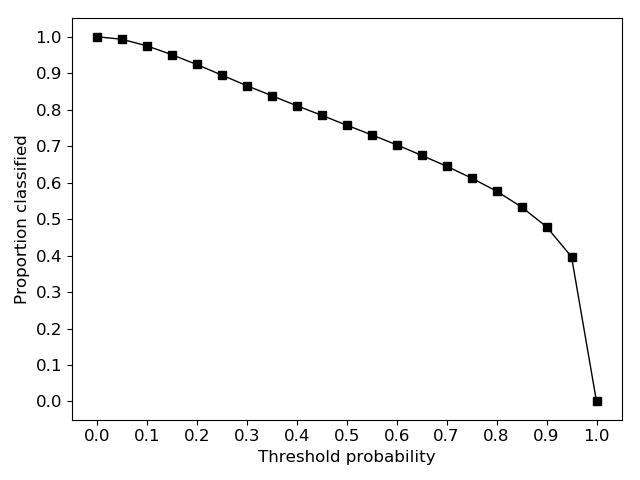

In [12]:
thresholds = []
proportions = []
with open('data/pred_reference/thresholds.csv', 'rt') as fp:
    reader = csv.reader(fp)
    for row in reader:
        thresholds.append(float(row[0]))
        proportions.append(float(row[1]))

plt.style.use('default')
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, proportions, 's-', color='black', linewidth='1', )
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(np.arange(0, 1.1, 0.1), fontdict={'size': 12})
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1), fontdict={'size': 12})
ax.set_ylabel("Proportion classified", fontdict={'size': 12})
ax.set_xlabel("Threshold probability", fontdict={'size': 12})

plt.tight_layout()
plt.savefig('threshold.png', format='png', dpi=600)
plt.show()